# Objectives:

### Declumping
- Automatically find clumpiness threshold (to ID clusters to which many contributors have contributed multiple times).

# Takeaways:

- Otsu's performs poorly as a clumpiness threshold. K-means performs well except when there is only one mode and we want that whole mode to be above the threshold.

- My threshold, which I am temporarily calling the "drop threshold," seems to perform well.
    - How to find threshold_drop:
        - Sort all clusters into bins: 100-95%, 95-85%, ..., 5-0% of contributors contributed only once to this cluster.
        - Find all values between two adjacent bins where the number of clusters in the higher-value bin is at least three times greater than the number of clusters in the lower-value bin, and neither bin contains zero clusters. 
        - threshold_drop is the lowest of these values minus 0.1 (to move one bin to the left, to minimize the number of clusters which are actually single in the group of clusters detected as clumpy), or 0 if no such values exist.

# Next steps:

- Do any of these clumpy clusters show obvious degrees of clumpiness (lots of workers annotate 2x, 3x, etc)? If so, we’d have the k needed to apply partitioning, e.g. k-means, to that clump.
    - Plot a histogram for each cluster with number of contributions from unique who contributes to the cluster.
    - The problem has an added layer of complexity exemplifed at (50, 220) on the scatter plot for snr_5_0_density_0.008_spots.png: two centroids were found for three actual spots. These two centroids are considered different clusters.
- Flag areas that need more zoomed-in annotation by detecting regions with a lot of clumpiness

# Guide to the scatter plots in this notebook
- Centroids are represented with unfilled circle markers.
    - The centroids of actual non-clumps (with only one reference spot within the area spanned by the cluster’s member annotations) are represented with bright blue unfilled circle markers.
    - The centroids of actual clumps (with at least two reference spots within the area spanned by the cluster’s member annotations) are represented with bright orange unfilled circle markers.
    - The centroids of incorrect clusters are represented with magenta unfilled circle markers.
- Annotations of “actually clumpy” clusters are represented with filled circle markers.
    - In some “actually clumpy” clusters, no contributing workers contributed more than one annotation. The member annotations of these clusters are shown as small light filled green circle markers.
    - In other “actually clumpy” clusters, at least one contributing worker contributed more than one annotation. THe member annotations of these clusters are shown small light pink filled circle markers.
- Reference annotations are represented with filled circle markers.
    - The reference annotation nearest to the centroid of a clumpy cluster is represented with a dark purple circle marker.
    - The reference annotation nearest to the centroid of a clumpy cluster is represented with a dark pink circle marker.
    - Other reference annotations are represented with light purple filled circle markers.


In [1]:
from SpotAnnotationAnalysis import SpotAnnotationAnalysis
from BaseAnnotation import BaseAnnotation
from QuantiusAnnotation import QuantiusAnnotation
import math
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from skimage import filters

%matplotlib inline

worker_marker_size = 8
cluster_marker_size = 40
bigger_window_size = True
img_height = 300
show_correctness = True
correctness_threshold = 4
clustering_params = ['AffinityPropagation', -350]

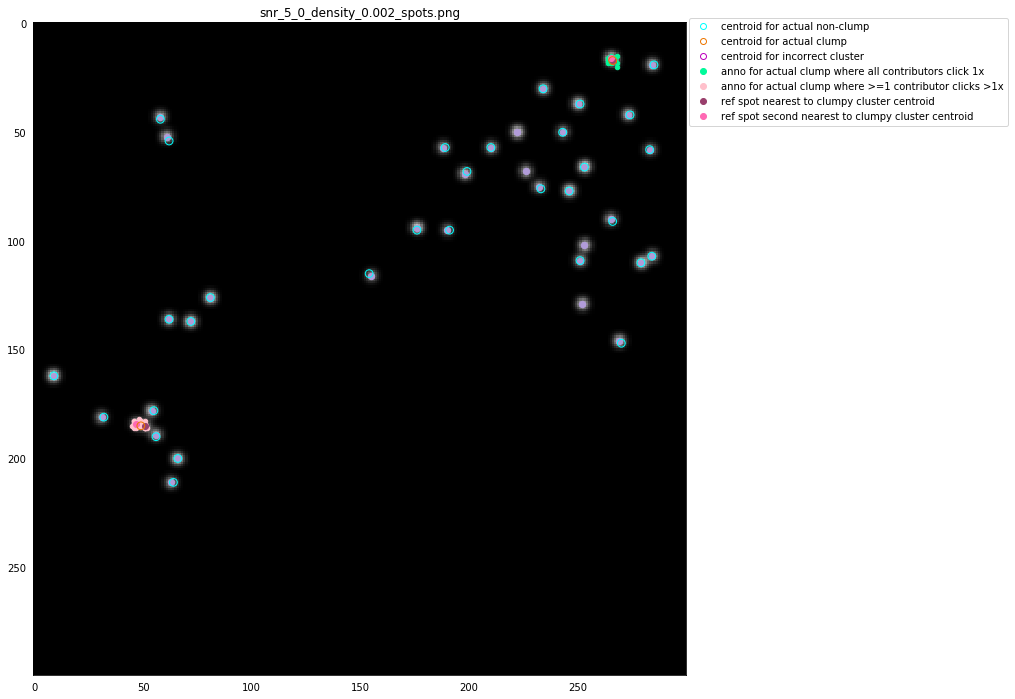

counts:
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  2. 30.]
---
prev_count 30.0
count 2.0
threshold_drop 0.85


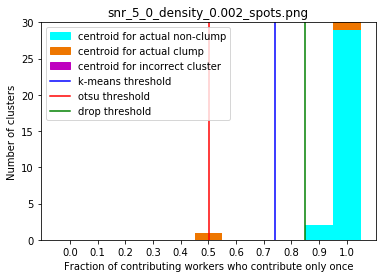

2 actual clumps
31 actual non-clumps


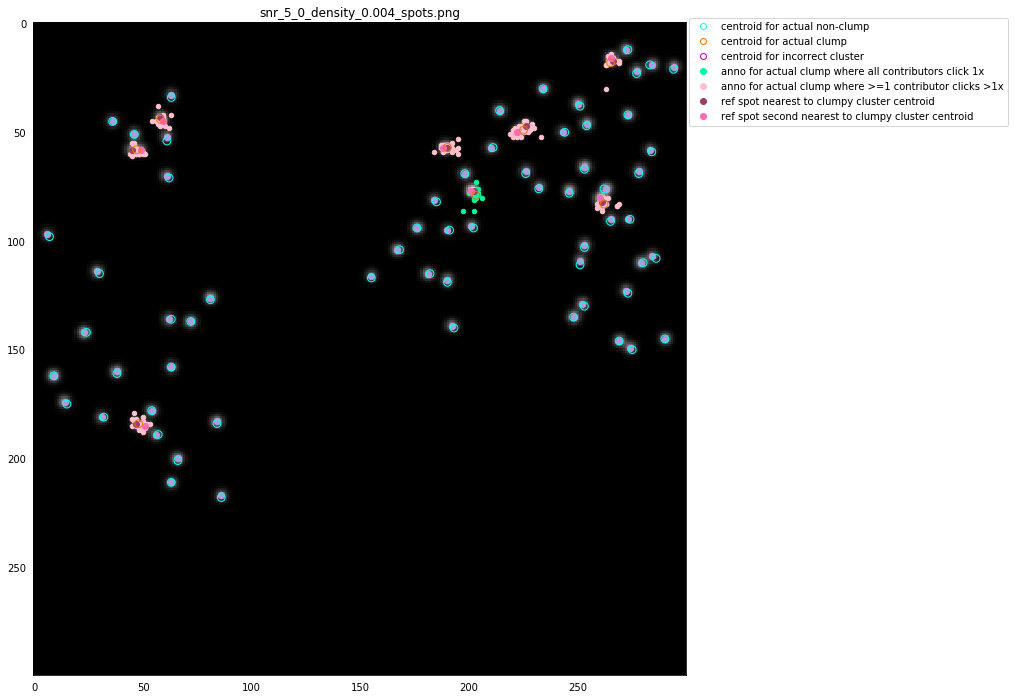

counts:
[ 0.  0.  0.  0.  1.  0.  0.  1.  3. 15. 50.]
---
prev_count 50.0
count 15.0
threshold_drop 0.85
---
prev_count 15.0
count 3.0
threshold_drop 0.75


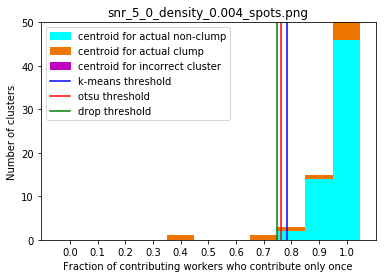

8 actual clumps
62 actual non-clumps


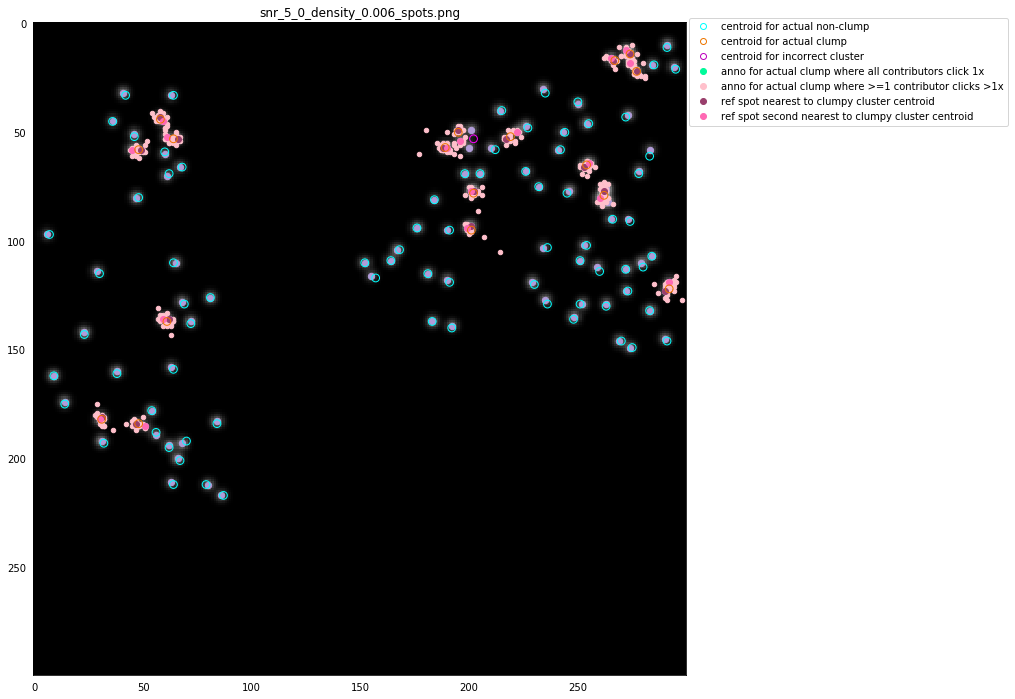

counts:
[ 0.  0.  0.  1.  0.  3.  2.  0.  5. 34. 51.]
---
prev_count 34.0
count 5.0
threshold_drop 0.75


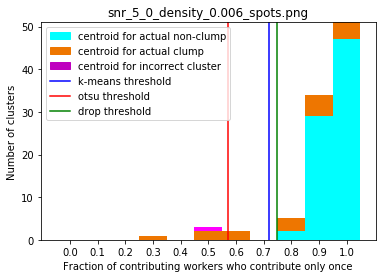

17 actual clumps
78 actual non-clumps


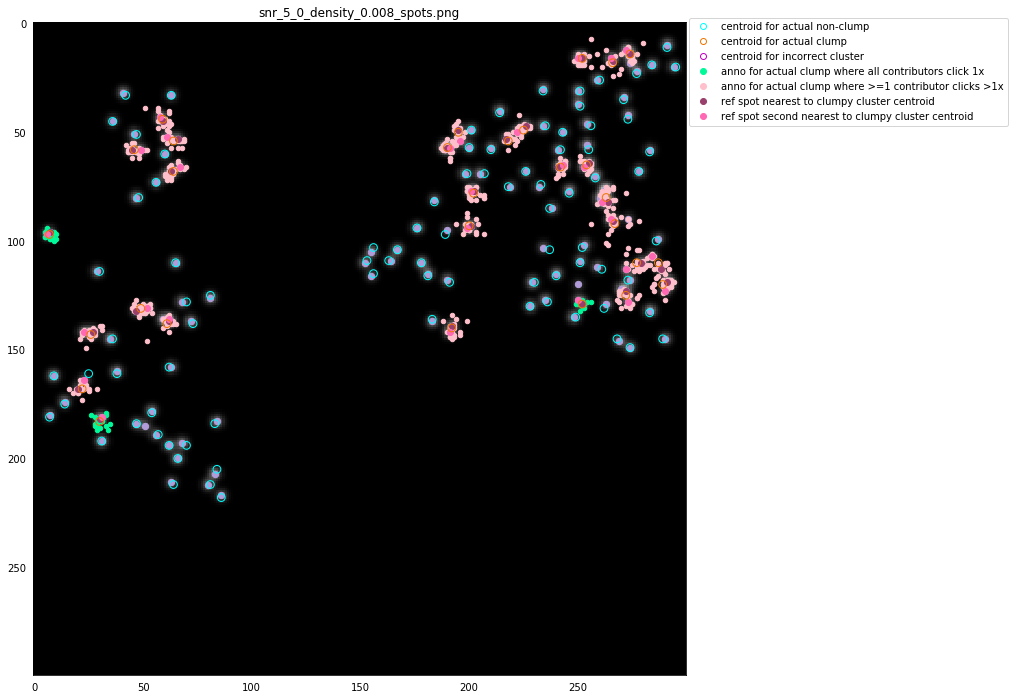

counts:
[ 0.  0.  0.  0.  3.  1.  5.  5. 10. 56. 37.]
---
prev_count 56.0
count 10.0
threshold_drop 0.75
---
prev_count 5.0
count 1.0
threshold_drop 0.45


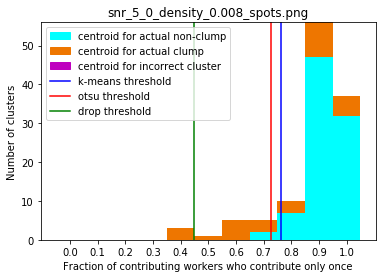

29 actual clumps
88 actual non-clumps


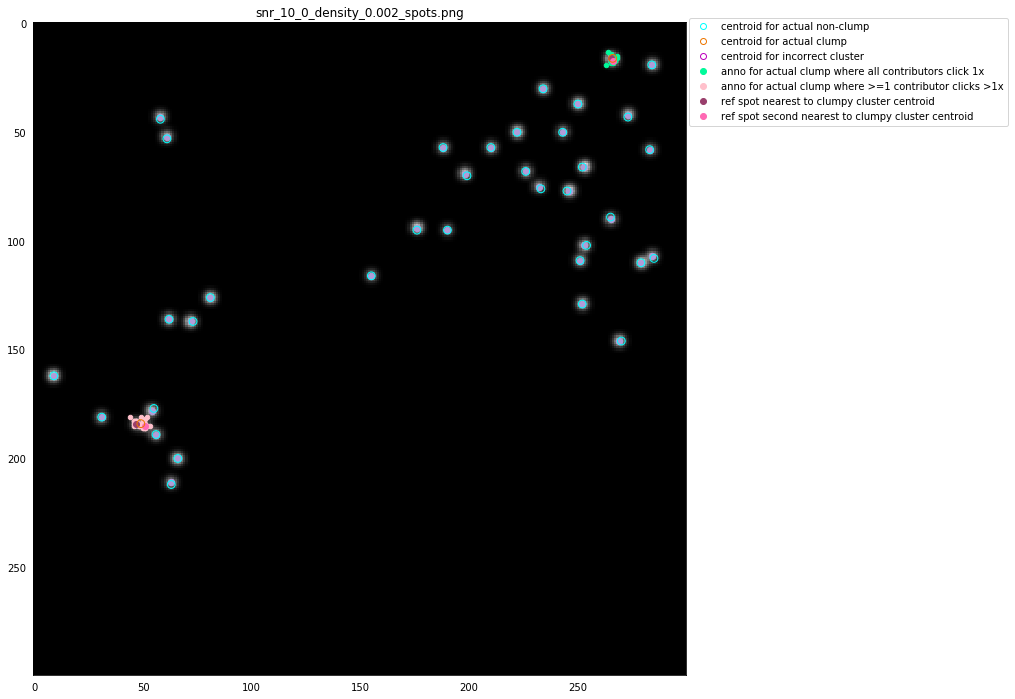

counts:
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0. 36.]


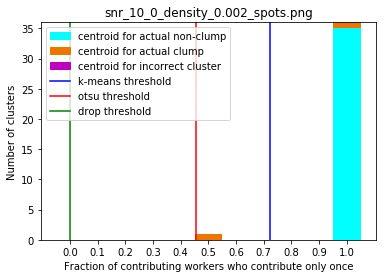

2 actual clumps
35 actual non-clumps


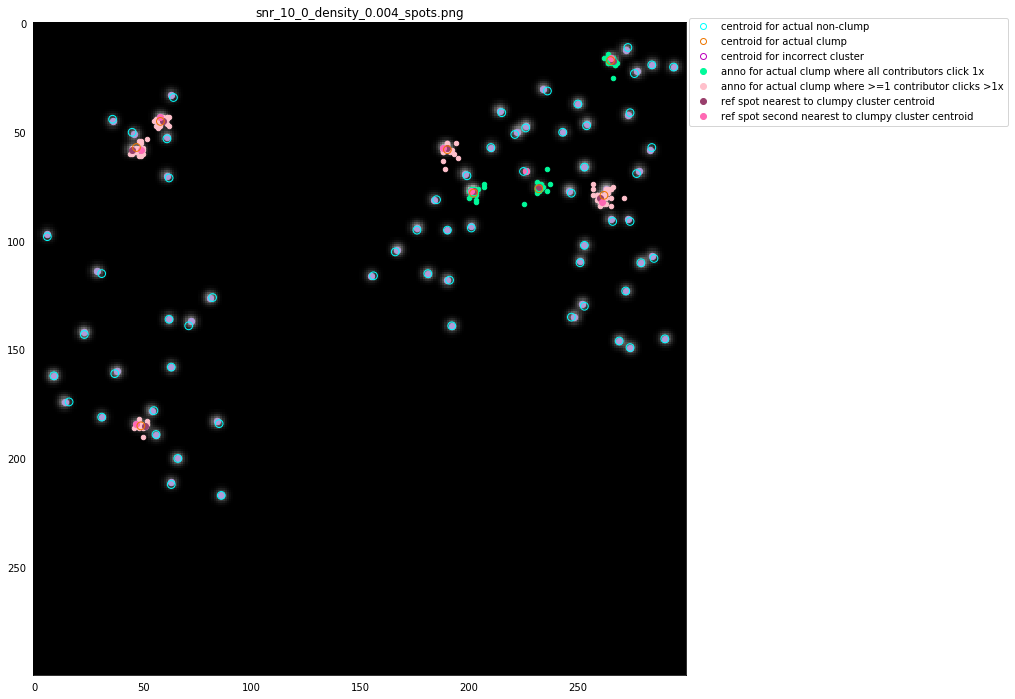

counts:
[ 0.  0.  0.  0.  1.  0.  0.  0.  1. 14. 54.]
---
prev_count 54.0
count 14.0
threshold_drop 0.85
---
prev_count 14.0
count 1.0
threshold_drop 0.75


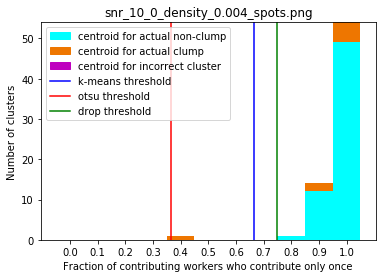

8 actual clumps
62 actual non-clumps


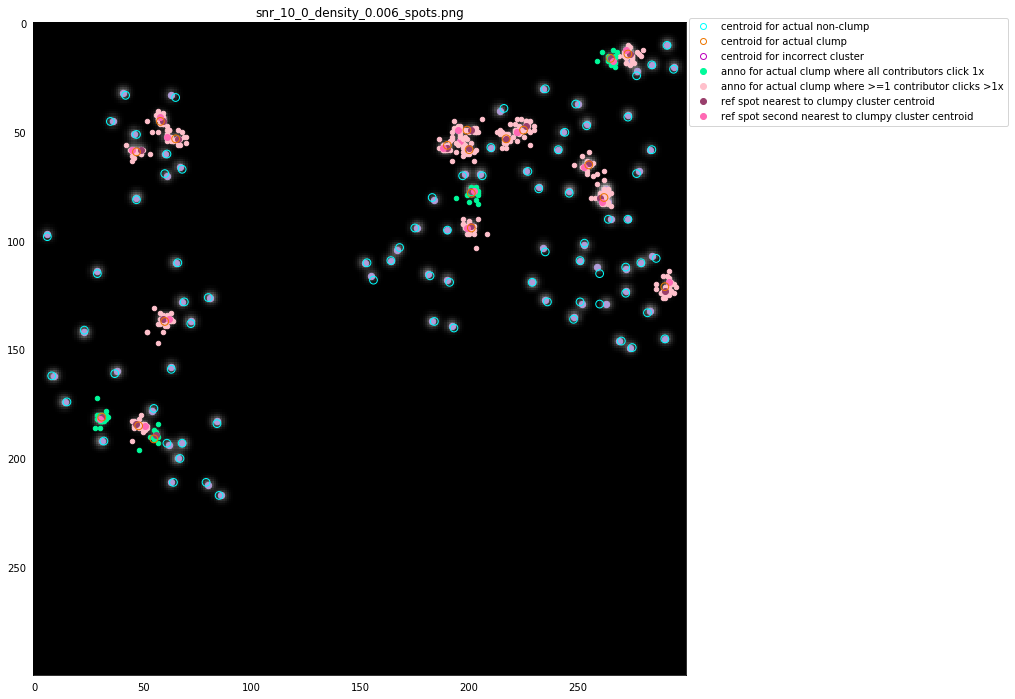

counts:
[ 0.  0.  0.  0.  1.  3.  1.  3.  5. 35. 48.]
---
prev_count 35.0
count 5.0
threshold_drop 0.75


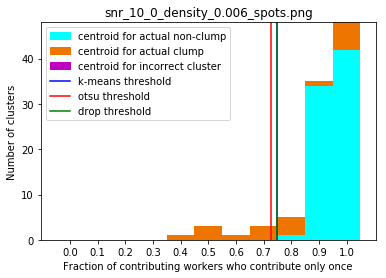

19 actual clumps
77 actual non-clumps


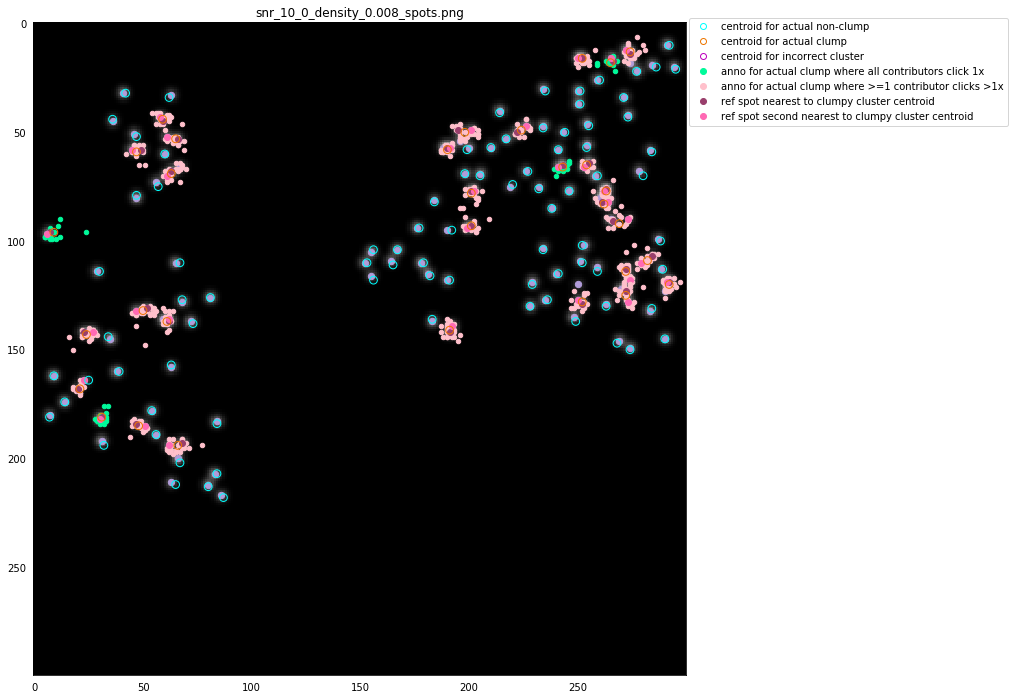

counts:
[ 0.  0.  0.  2.  1.  3.  3.  4.  7. 38. 58.]
---
prev_count 38.0
count 7.0
threshold_drop 0.75


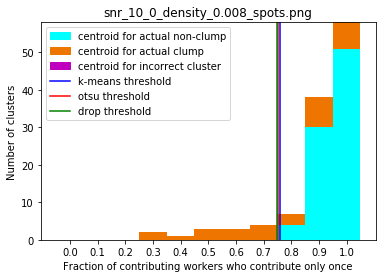

31 actual clumps
85 actual non-clumps


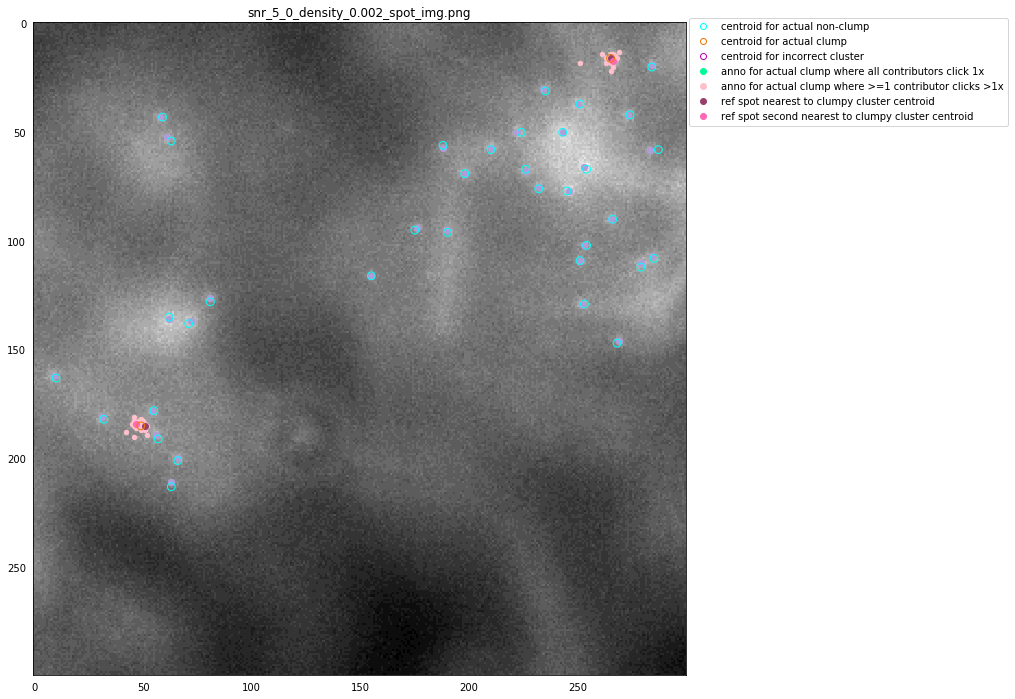

counts:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0. 15. 22.]


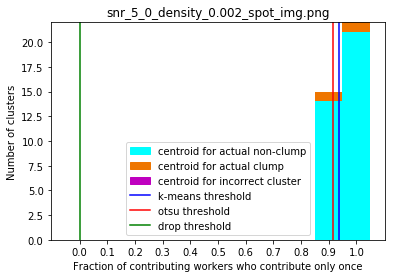

2 actual clumps
35 actual non-clumps


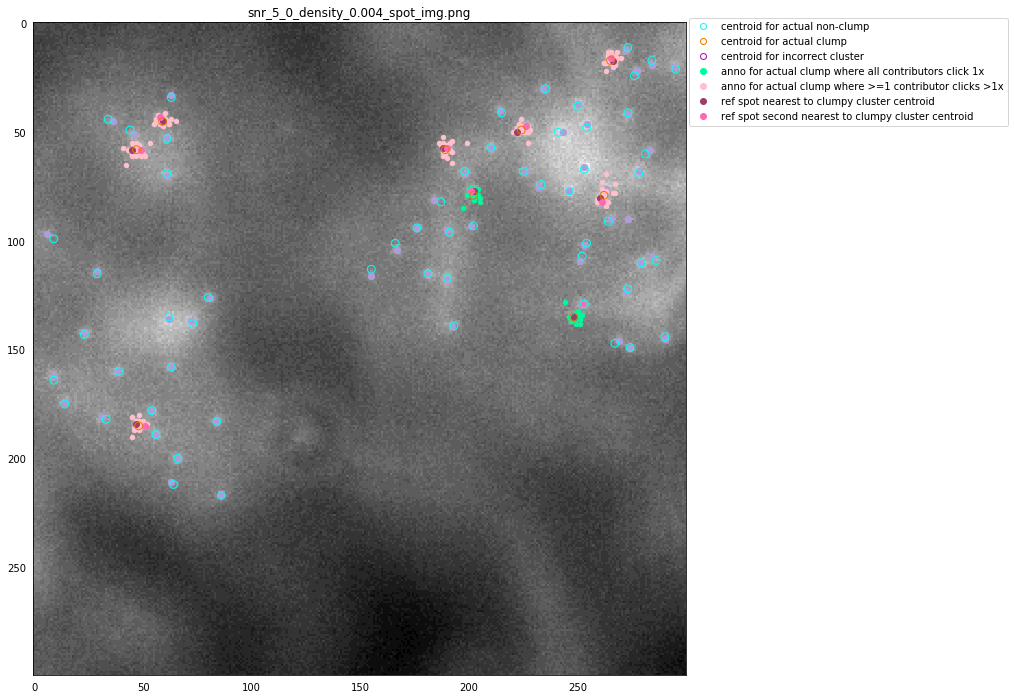

counts:
[ 0.  0.  0.  0.  0.  0.  0.  0.  2. 28. 38.]
---
prev_count 28.0
count 2.0
threshold_drop 0.75


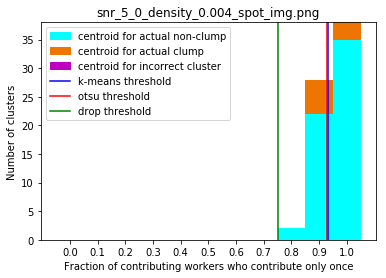

9 actual clumps
59 actual non-clumps


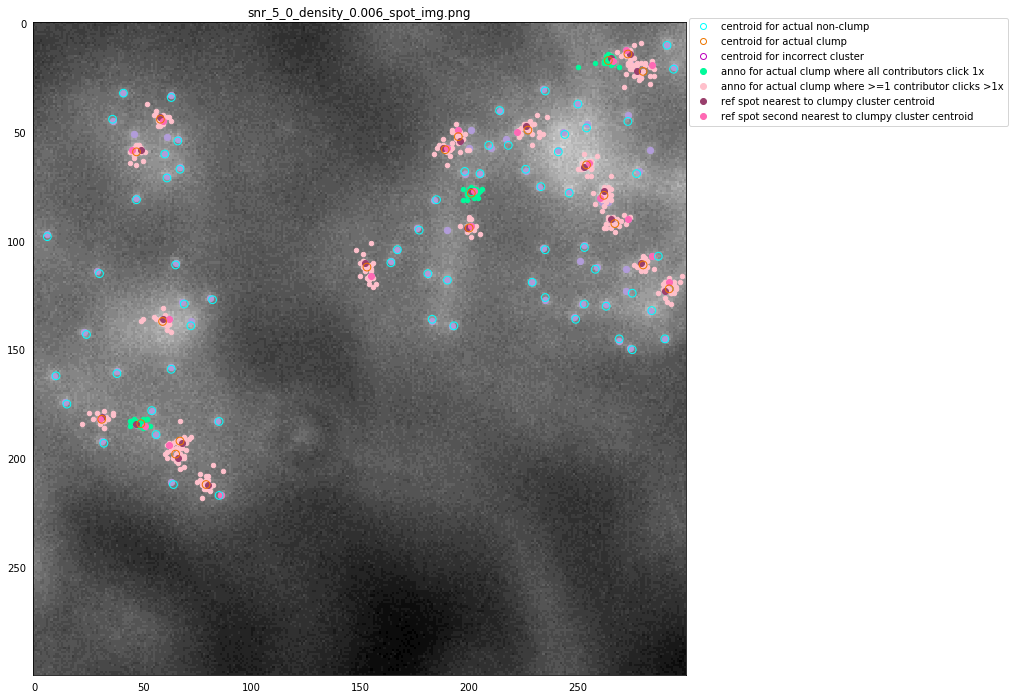

counts:
[ 0.  0.  0.  0.  0.  2.  3.  3.  3. 32. 43.]
---
prev_count 32.0
count 3.0
threshold_drop 0.75


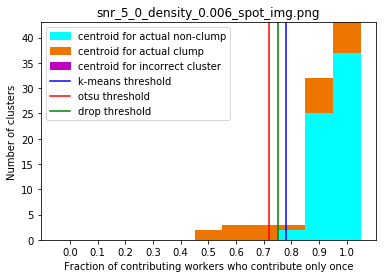

22 actual clumps
64 actual non-clumps


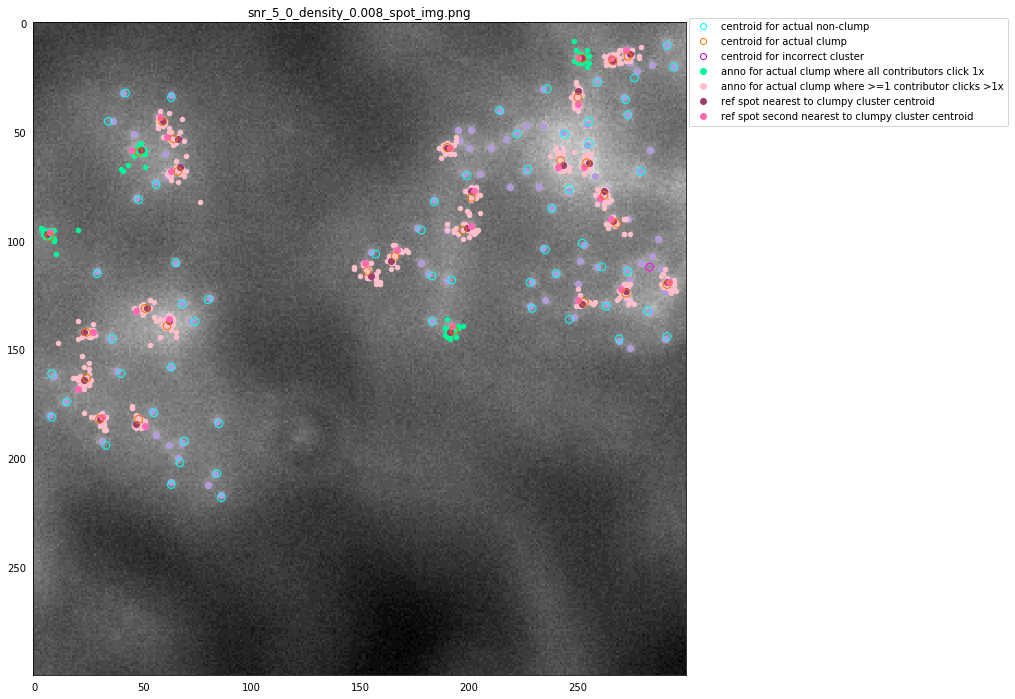

counts:
[ 0.  0.  0.  0.  1.  1.  3.  2.  9. 38. 34.]
---
prev_count 38.0
count 9.0
threshold_drop 0.75
---
prev_count 9.0
count 2.0
threshold_drop 0.6499999999999999


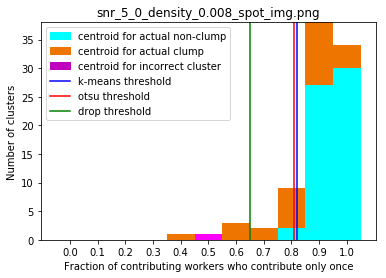

28 actual clumps
59 actual non-clumps


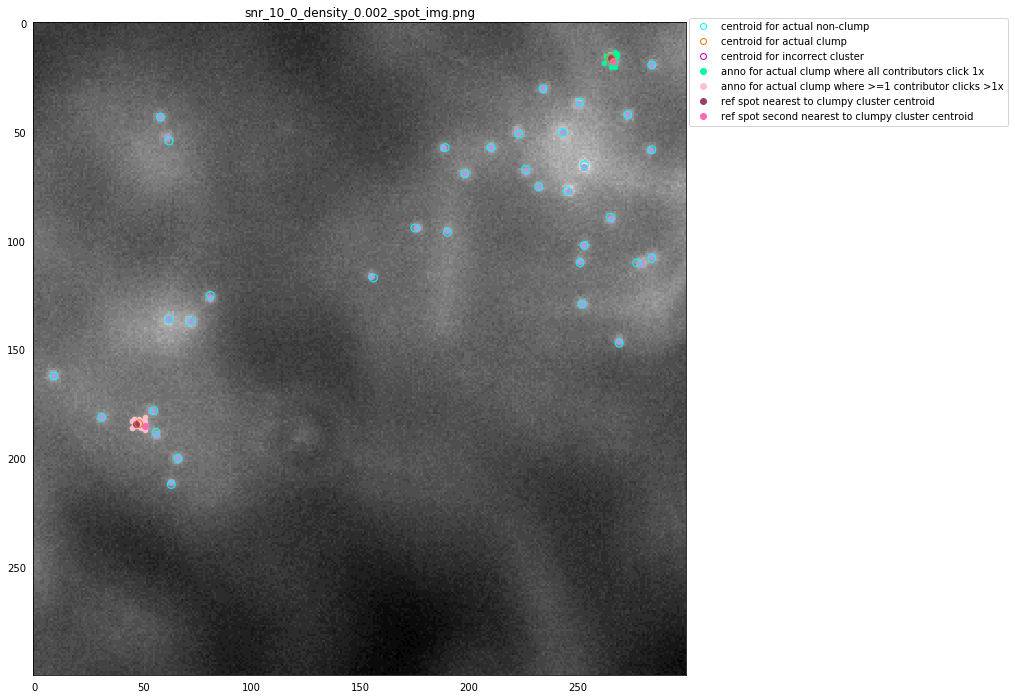

counts:
[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  2. 34.]
---
prev_count 34.0
count 2.0
threshold_drop 0.85


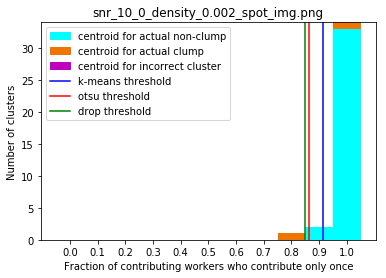

2 actual clumps
35 actual non-clumps


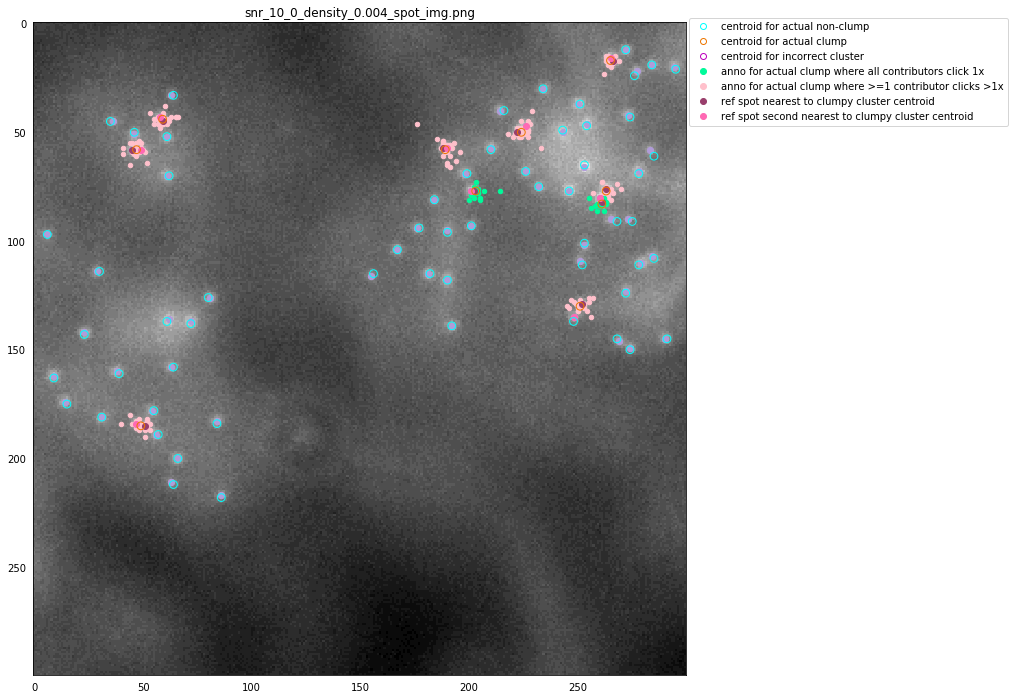

counts:
[ 0.  0.  0.  0.  1.  0.  0.  0.  4. 13. 52.]
---
prev_count 52.0
count 13.0
threshold_drop 0.85
---
prev_count 13.0
count 4.0
threshold_drop 0.75


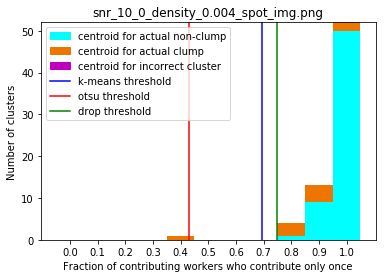

10 actual clumps
60 actual non-clumps


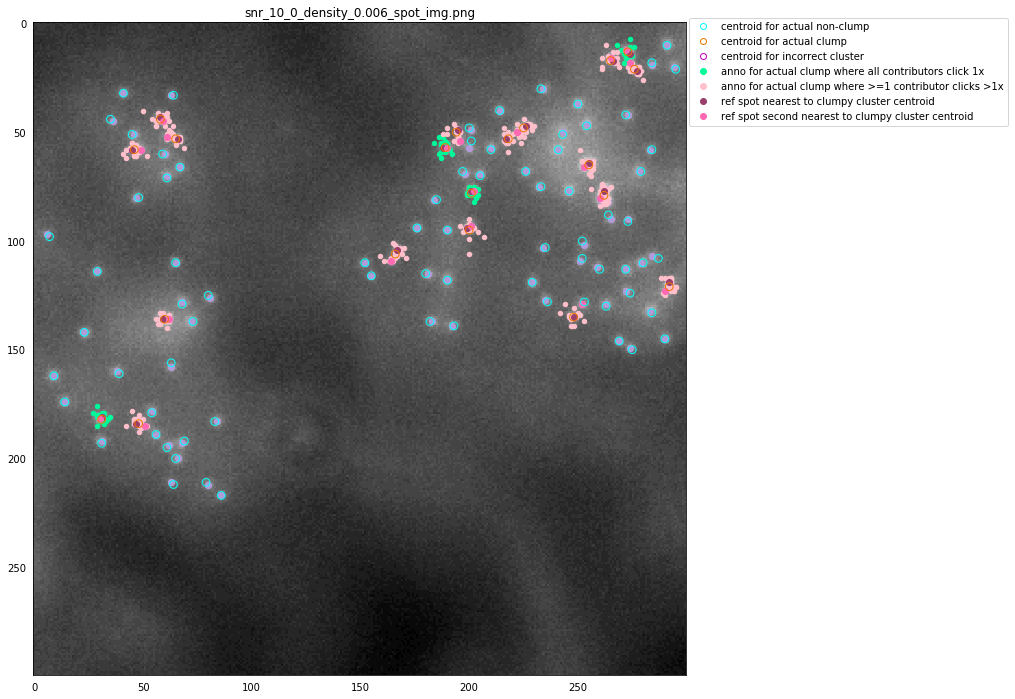

counts:
[ 0.  0.  0.  0.  0.  1.  1.  2.  5. 36. 51.]
---
prev_count 36.0
count 5.0
threshold_drop 0.75


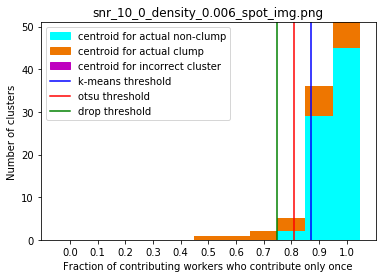

20 actual clumps
76 actual non-clumps


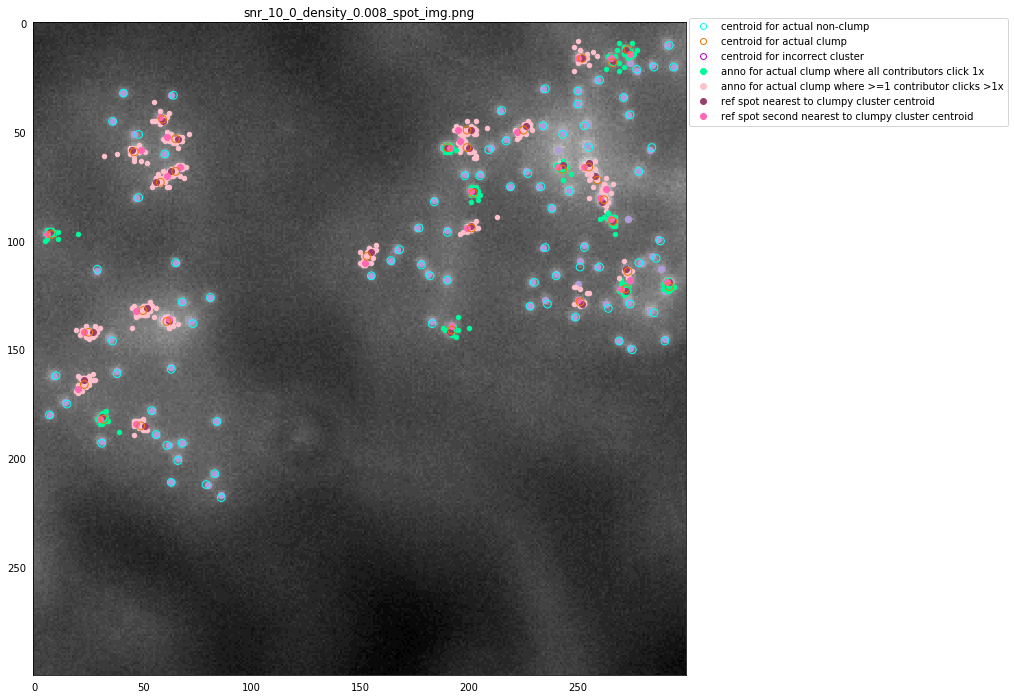

counts:
[ 0.  0.  0.  0.  1.  3.  2.  1.  6. 27. 74.]
---
prev_count 27.0
count 6.0
threshold_drop 0.75
---
prev_count 6.0
count 1.0
threshold_drop 0.6499999999999999


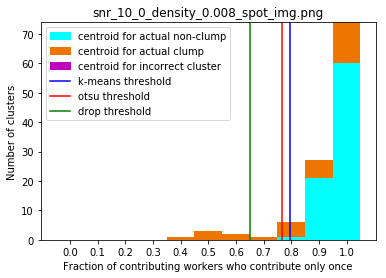

32 actual clumps
82 actual non-clumps


In [2]:
json_filename_list = ['Spots_density_no_tissue.json','Spot_density.json']
density_list = [0.002, 0.004, 0.006, 0.008]
snr_mu_list = [5, 10]
# json_filename_list = ['Spots_density_no_tissue.json']
# density_list = [0.002]
# snr_mu_list = [5]

for json_filename in json_filename_list:
    for snr_mu in snr_mu_list:
        for density in density_list:
            img_name = 'snr_' + str(snr_mu)+ '_0_density_' + str(density)
            if (json_filename == 'Spots_density_no_tissue.json'):
                img_filename = img_name+'_spots.png'
                img_filepath = '/Users/jenny.vo-phamhi/Documents/FISH-annotation/Annotation/density_test/spot_arrays/'+img_filename
            else:
                img_filename = img_name+'_spot_img.png'
                img_filepath = '/Users/jenny.vo-phamhi/Documents/FISH-annotation/Annotation/density_test/spot_images/'+img_filename
            csv_filepath = '/Users/jenny.vo-phamhi/Documents/FISH-annotation/Annotation/density_test/spot_data/'+img_name+'_coord_snr_list.csv'
            json_filepath = '/Users/jenny.vo-phamhi/Documents/FISH-annotation/Annotation/density_test/'+json_filename

            ba = QuantiusAnnotation(json_filepath)
            sa = SpotAnnotationAnalysis(ba)
            anno_all = ba.df()
            anno_one_image = ba.slice_by_image(anno_all, img_filename)
            ref_kdt = sa.csv_to_kdt(csv_filepath, img_height)
            ref_array = np.asarray(ref_kdt.data)

            # Get large clusters
            clusters = sa.get_clusters(anno_one_image, clustering_params)
            total_num_clusters = len(clusters.index)
            threshold = sa.get_cluster_size_threshold(clusters)
            threshold = math.ceil(threshold)
            small_clusters, large_clusters = sa.sort_clusters_by_size_input_threshold(clusters, threshold)
            
            # For each cluster, calc and sort replication of each worker
            actual_clumps = []
            not_actual_clumps = []
            incorrect_clusters = []
            actual_clump_centroids = []
            not_actual_clump_centroids = []
            incorrect_centroids = []
            
            fig = plt.figure(figsize=(14,12))
            
            # plot ref points
            ref_df = pd.read_csv(csv_filepath)
            ref_points = ref_df.loc[:, ['col', 'row']].as_matrix()
            for point in ref_points:
                plt.scatter([point[0]], [point[1]], c='#b19cd9', s=40)
            
            for i in range(len(large_clusters.index)):
                row = large_clusters.iloc[[i]]
                members = row.iloc[0]['members']
                workers = []
                x_coords = []
                y_coords = []
                for member in members:
                    x_coords.append(member[0])
                    y_coords.append(member[1])
                    workers.append(member[3])
                    
                # Calculate replication of unique workers for each cluster
                unique_workers = np.unique(workers)
                num_instances_list = []
                for unique_worker in unique_workers:
                    num_instances_list.append(workers.count(unique_worker))
                singles = num_instances_list.count(1)
                single_fraction = singles/len(unique_workers)
    
                # Are there at least two ref spots in the area of this cluster? (Is this cluster actually clumpy?)  
                centroid_coord = [row.iloc[0]['centroid_x'], row.iloc[0]['centroid_y']]
                dist, ind = ref_kdt.query([centroid_coord],k=2)
                index_0 = ind[0][0]
                index_1 = ind[0][1]
                neighbor_0 = ref_array[index_0]
                neighbor_1 = ref_array[index_1]
                if(dist[0][0] <= 4):
                    if ((neighbor_0[0] >= min(x_coords)) and (neighbor_0[0] <= max(x_coords)) and
                        (neighbor_0[1] >= min(y_coords)) and (neighbor_0[1] <= max(y_coords)) and 
                        (neighbor_1[0] >= min(x_coords)) and (neighbor_1[0] <= max(x_coords)) and
                        (neighbor_1[1] >= min(y_coords)) and (neighbor_1[1] <= max(y_coords))):
                        cluster_is_clumpy = True
                        if(single_fraction == 1):
                            color = '#00fa9a'
                        else:
                            color = '#ffC0cb'
                        plt.scatter(x_coords, ba.flip(y_coords, img_height), c=color, s=20)
                        plt.scatter([neighbor_0[0]], [img_height-neighbor_0[1]], c='#993f6c')
                        plt.scatter([neighbor_1[0]], [img_height-neighbor_1[1]], c='#ff69b4')

                    else:
                        cluster_is_clumpy = False
                    if cluster_is_clumpy:
                        actual_clumps.append(single_fraction)
                        actual_clump_centroids.append(centroid_coord)
                    else:
                        not_actual_clumps.append(single_fraction)
                        not_actual_clump_centroids.append(centroid_coord)
                else:
                    incorrect_clusters.append(single_fraction)
                    incorrect_centroids.append(centroid_coord)

            # plot centroids
            actual_clump_centroids = np.asarray(actual_clump_centroids)
            not_actual_clump_centroids = np.asarray(not_actual_clump_centroids)
            incorrect_centroids = np.asarray(incorrect_centroids)
            plt.scatter(not_actual_clump_centroids[:,0], ba.flip(not_actual_clump_centroids[:,1], img_height), facecolors = 'None', edgecolors ='#00ffff', s=60)
            plt.scatter(actual_clump_centroids[:,0], ba.flip(actual_clump_centroids[:,1], img_height), facecolors = 'None', edgecolors ='#ee7600', s=60)
            if (incorrect_centroids.size > 0):
                plt.scatter(incorrect_centroids[:,0], ba.flip(incorrect_centroids[:,1], img_height), facecolors = 'None', edgecolors ='magenta', s=60)
                
            # plot image
            img = mpimg.imread(img_filepath)
            plt.tick_params(
                axis='both',
                which='both',
                bottom=False,
                top=False,
                left=False,
                right=False)
            plt.imshow(img, cmap = 'gray')
            
            # legend elements
            leg_elem_1 = Line2D([0], [0], marker='o', color = 'None', markeredgecolor='#00ffff', markerfacecolor='None', label='centroid for actual non-clump')
            leg_elem_2 = Line2D([0], [0], marker='o', color = 'None', markeredgecolor='#ee7600', markerfacecolor='None', label='centroid for actual clump')
            leg_elem_3 = Line2D([0], [0], marker='o', color = 'None', markeredgecolor='m', markerfacecolor='None', label='centroid for incorrect cluster')
            leg_elem_4 = Line2D([0], [0], marker='o', color = 'None', markeredgecolor='#00fa9a', markerfacecolor='#00fa9a', label='anno for actual clump where all contributors click 1x')
            leg_elem_5 = Line2D([0], [0], marker='o', color = 'None', markeredgecolor='#ffC0cb', markerfacecolor='#ffC0cb', label='anno for actual clump where >=1 contributor clicks >1x')
            leg_elem_6 = Line2D([0], [0], marker='o', color = 'None', markeredgecolor='#993f6c', markerfacecolor='#993f6c', label='ref spot nearest to clumpy cluster centroid')
            leg_elem_7 = Line2D([0], [0], marker='o', color = 'None', markeredgecolor='#ff69b4', markerfacecolor='#ff69b4', label='ref spot second nearest to clumpy cluster centroid')
            handle_list = [leg_elem_1, leg_elem_2, leg_elem_3, leg_elem_4, leg_elem_5, leg_elem_6, leg_elem_7]
            plt.legend(handles = handle_list, loc = 9, bbox_to_anchor = (1.25, 1.015))
            
            plt.title(img_filename)
            plt.show()
            
            # plot single fraction histograms
            fig = plt.figure()
            (n, bins, patches) = plt.hist([not_actual_clumps, actual_clumps, incorrect_clusters], stacked = True, color = ['#00ffff', '#ee7600', 'magenta'], bins = np.arange(0,1.2,0.1)-0.05)

            # calc drop-off threshold
            total_counts = n[2]
            print('counts:')
            print(total_counts)
            total_counts_rev = list(reversed(total_counts))
            
            threshold_drop = 0
            prev_count = 0
            for i in range(len(total_counts_rev)):
                count = total_counts_rev[i]
                if (count != 0):
                    if((count < prev_count/3) and (count != 0) and (prev_count != 0)):
                        threshold_drop = 1-i*0.1-0.05
                        print('---')
                        print('prev_count ' + str(prev_count))
                        print('count ' + str(count))
                        print('threshold_drop ' + str(threshold_drop))
                prev_count = count
                
            # calc k-means threshold
            total_list = not_actual_clumps + actual_clumps + incorrect_clusters
            total_array = np.asarray(total_list)
            km = KMeans(n_clusters = 2).fit(total_array.reshape(-1,1))
            cluster_centers = km.cluster_centers_
            threshold_kmeans = (cluster_centers[0][0]+cluster_centers[1][0])/2
            
            # calc otsu threshold
            threshold_otsu = filters.threshold_otsu(np.asarray(total_list))
            
            plt.xlabel('Fraction of contributing workers who contribute only once')
            plt.ylabel('Number of clusters')
            plt.xticks(np.arange(0,1.1, 0.1))
            
            blue_patch = mpatches.Patch(color='#00ffff', label='centroid for actual non-clump')
            orange_patch = mpatches.Patch(color='#ee7600', label='centroid for actual clump')
            magenta_patch = mpatches.Patch(color='m', label='centroid for incorrect cluster')
            kmeans_line = Line2D([0],[0], color='b', label='k-means threshold')
            otsu_line = Line2D([0],[0], color='r', label='otsu threshold')
            drop_line = Line2D([0],[0], color = 'g', label='drop threshold')
            
            plt.legend(handles=[blue_patch, orange_patch, magenta_patch, kmeans_line, otsu_line, drop_line])
            plt.axvline(x=threshold_kmeans, color='blue')
            plt.axvline(x=threshold_otsu, color='red')
            plt.axvline(x=threshold_drop, color='green')
            
            plt.title(img_filename)
            plt.show()
            print(str(len(actual_clumps)) + ' actual clumps')
            print(str(len(not_actual_clumps)) + ' actual non-clumps')
            
            